In [1]:
import math
import random
import time
import pdb

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import networkx as nx
import dgl

Using backend: pytorch


In [2]:
from policies.pytorch_custom_lstm import LayerNormLSTMCell, test_script_stacked_lnlstm
test_script_stacked_lnlstm(5, 2, 3, 7, 4)

/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/jit/_recursive.py:165: UserWarning: 'layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [5]:
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines.common.cmd_util import make_vec_env

from envs.Collins2018 import Collins2018Task

num_envs = 2
env = Collins2018Task(num_objects=(3, 3), num_actions=3, num_repeats=6)
envs = make_vec_env(lambda: env, n_envs=num_envs)


/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/

In [6]:
envs.num_envs

2

<h2>Neural Network</h2>

In [7]:
class A2C_LSTM(nn.Module):
    """Container Module with a LSTM layer leading to an action and value network module."""
    
    def __init__(self, num_inputs, num_outputs, num_LSTM):
        super().__init__()
        self.rnn = LayerNormLSTMCell(num_inputs, num_LSTM)
        self.actor = nn.Sequential(
            nn.Linear(num_LSTM, num_outputs),
            nn.LogSoftmax(dim=-1)
        )
        self.critic = nn.Linear(num_LSTM, 1)
        
        self.num_LSTM = num_LSTM
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        
        self.init_weights()
        
    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        value = self.critic(output)
        action_log_prob = self.actor(output)
        action_prob = Categorical(logits=action_log_prob)
        return action_prob, value, hidden
        
    def init_weights(self):
        init_scale = 1.4
        self.actor[0].weight.data.uniform_(-init_scale, init_scale)
        self.actor[0].bias.data.zero_()
        self.critic.weight.data.uniform_(-init_scale, init_scale)
        self.critic.bias.data.zero_()
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (
            weight.new_zeros(batch_size, num_LSTM),
            weight.new_zeros(batch_size, num_LSTM)
        )

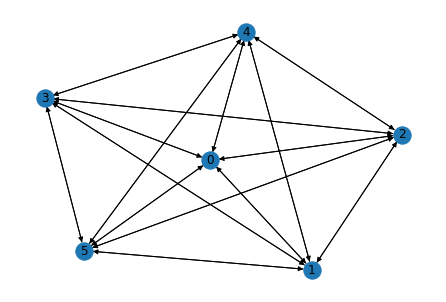

In [28]:
# draw a graph with N nodes
def make_clique(num_nodes, draw_graph=False):
    """Create a Clique with num_nodes nodes."""
    u, v = [], []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j: continue
            u.append(i)
            v.append(j)

    g = dgl.DGLGraph((u, v))
    if draw_graph: nx.draw(g.to_networkx(), with_labels=True)
    return g

gg = make_clique(6, True)

In [9]:
class GRNLayer(nn.Module):
    def __init__(self, g, num_inputs, num_hidden):
        super().__init__()
        self.w_i = nn.Linear(num_inputs, num_hidden, bias=False)
        self.attn_i = nn.Linear(2*num_hidden, 1, bias=False)
        self.w_h = nn.Linear(2*num_hidden, num_hidden, bias=False)
        self.attn_h = nn.Linear(2*num_hidden, 1, bias=False)
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.g = g
        self.reset_parameters()
        
    def reset_parameters(self):
        """Reset learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.w_i.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_i.weight, gain=gain)
    
    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=2)
        a_h = self.attn_h(z2)
        return {'e': F.leaky_relu(a_h)}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        a_h = F.softmax(nodes.mailbox['e'], dim=1)
        h = torch.sum(a_h * nodes.mailbox['z'], dim=1)
        return {'h': h}
        
    def forward(self, state, hidden):
        z_i = self.w_i(state)
        a_i = F.softmax(torch.matmul(hidden, z_i.unsqueeze_(2)), dim=1)
        # deprecated outer product function, should be torch.outer in the future
        h_i = torch.cat([torch.ger(a_i[b, :, 0], z_i[b, :, 0]).unsqueeze_(0) for b in range(hidden.size(0))], 0)
        h_concat = torch.cat([hidden, h_i], dim=2)
        
        z = self.w_h(h_concat)
        self.g.ndata['z'] = z.transpose_(0, 1)  # change to (num_nodes, batch_size)
        self.g.apply_edges(self.edge_attention)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h').transpose_(0, 1)  # change to (batch_size, num_nodes)


In [10]:
class MultiHeadGRNLayer(nn.Module):
    def __init__(self, g, num_inputs, num_hidden, num_heads, merge='cat'):
        super().__init__()
        self.g = g
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GRNLayer(g, num_inputs, num_hidden))
        self.merge = merge
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_heads = num_heads

    def forward(self, state, hidden):
        h_split = torch.split(hidden, num_hidden, dim=2)
        head_outs = [attn_head(state, h) for attn_head, h in zip(self.heads, h_split)]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=2)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [11]:
class A2C_GRN(nn.Module):
    def __init__(self, g, num_inputs, num_outputs, num_hidden, num_heads, num_iterations):
        super().__init__()
        self.g = g
        self.layer = MultiHeadGRNLayer(g, num_inputs, num_hidden, num_heads)
        self.actor = nn.Sequential(
            nn.Linear(num_hidden * num_heads * g.number_of_nodes(), num_outputs),
            nn.LogSoftmax(dim=-1)
        )
        self.critic = nn.Linear(num_hidden * num_heads * g.number_of_nodes(), 1)
        self.num_iterations = num_iterations
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hidden = num_hidden
        self.num_heads = num_heads
        
    def init_weights(self):
        self.layer.reset_parameters()
        init_scale = 1.4
        self.actor[0].weight.data.uniform_(-init_scale, init_scale)
        self.actor[0].bias.data.zero_()
        self.critic.weight.data.uniform_(-init_scale, init_scale)
        self.critic.bias.data.zero_()
        
    def init_hidden(self, batch_size):
        hidden = torch.randn(batch_size, self.g.number_of_nodes(), self.num_hidden * self.num_heads)
        return nn.init.normal_(hidden)
        
    
    def forward(self, state, hidden):
        for it in range(self.num_iterations):
            hidden = self.layer(state, hidden)
        value = self.critic(torch.reshape(hidden, (hidden.size(0), -1)))
        action_log_prob = self.actor(torch.reshape(hidden, (hidden.size(0), -1)))
        action_prob = Categorical(logits=action_log_prob)
        return action_prob, value, hidden
    
    


In [12]:
num_inputs = 3
num_outputs = 3  # num_actions
num_hidden = 5
num_nodes = 7
num_heads = 3
num_iteration = 5
state = torch.FloatTensor([1, 1, 1]).to(device)
hidden = torch.randn(num_nodes, num_hidden * num_heads)

g = make_clique(num_nodes)

#model = GRNLayer(g, num_inputs, num_hidden)
#hidden_out = model(state, hidden)
#print(hidden_out.size())

#model2 = MultiHeadGRNLayer(g, num_inputs, num_hidden, num_heads)
#hidden_out2 = model2(state, hidden)
#print(hidden_out2.size())

#model3 = A2C_GRN(g, num_inputs, num_outputs, num_hidden, num_heads, num_iteration)
#hidden = model3.init_hidden(2)
#print(hidden.size())
#prob, value, hi = model3(state, hidden)
#print(prob)
#print(value)
#print(hi.size())

In [13]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = envs.reset()
    if vis: envs.render()
    done = [False] * envs.num_envs
    total_reward = 0
    hidden = model.init_hidden(envs.num_envs)
    
    while not any(done):
        state = torch.FloatTensor(state).to(device)
        dist, _, hidden = model(state, hidden)
        
        next_state, reward, done, _ = envs.step(dist.sample().cpu().numpy())
        state = next_state`
        if vis: envs.render()
        total_reward += reward
    return total_reward

<h1>A2C: Synchronous Advantage Actor Critic</h1>
<h3><a href="https://blog.openai.com/baselines-acktr-a2c/#a2canda3c">OpenAI Blog:</a></h3>
<p>The Asynchronous Advantage Actor Critic method (A3C) has been very influential since the paper was published. The algorithm combines a few key ideas:</p>

<ul>
    <li>An updating scheme that operates on fixed-length segments of experience (say, 20 timesteps) and uses these segments to compute estimators of the returns and advantage function.</li>
    <li>Architectures that share layers between the policy and value function.</li>
    <li>Asynchronous updates.</li>
</ul>

<p>After reading the paper, AI researchers wondered whether the asynchrony led to improved performance (e.g. “perhaps the added noise would provide some regularization or exploration?“), or if it was just an implementation detail that allowed for faster training with a CPU-based implementation.</p>

<p>As an alternative to the asynchronous implementation, researchers found you can write a synchronous, deterministic implementation that waits for each actor to finish its segment of experience before performing an update, averaging over all of the actors. One advantage of this method is that it can more effectively use of GPUs, which perform best with large batch sizes. This algorithm is naturally called A2C, short for advantage actor critic. (This term has been used in several papers.)</p>

In [14]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [15]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
num_LSTM    = 20
lr          = 7e-4
num_steps   = 5
batch_size  = 1

model_LSTM = A2C_LSTM(num_inputs, num_outputs, num_LSTM).to(device)
optimizer = optim.RMSprop(model_LSTM.parameters(), lr=lr)

In [16]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n
num_hidden = 10
num_nodes = 6
num_heads = 3
num_iterations = 1
lr = 7e-4
num_steps = 5
batch_size = 2

g = make_clique(num_nodes)
model_GRN = A2C_GRN(g, num_inputs, num_outputs, num_hidden, num_heads, num_iterations).to(device)
optimizer = optim.RMSprop(model_GRN.parameters(), lr=lr)

In [17]:
max_frames   = 20_000_000
frame_idx    = 0
test_rewards = []

In [18]:
t_record = time.time()
model = model_GRN
while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = []
    
    done = [False] * num_envs
    state = envs.reset()
    hidden = model.init_hidden(batch_size)

    while not any(done):
        state = torch.FloatTensor(state).to(device)
        dist, value, hidden = model(state, hidden)
        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(1)
        
        entropy.append(dist.entropy().unsqueeze(1))
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 10000 == 0:
            test_reward = np.mean([test_env() for _ in range(5)])
            test_rewards.append(test_reward)
            print(f'at frame {int(frame_idx)},\t mean testing reward {test_reward :.2f}')
            
        if frame_idx % 10000 == 0:
            #plot(frame_idx, test_rewards)
            print(f'at frame {int(frame_idx)},\t takes time {(time.time() - t_record) :.2f} seconds')

    returns = compute_returns(torch.zeros(envs.num_envs, 1), rewards, masks, gamma=0.9)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)
    entropy = torch.cat(entropy).mean()
    
    
    advantage = returns - values
    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    loss = actor_loss + 0.05 * critic_loss - 0.05 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

at frame 10000,	 mean testing reward 2.80
at frame 10000,	 takes time 61.83 seconds
at frame 20000,	 mean testing reward 3.00
at frame 20000,	 takes time 121.52 seconds
at frame 30000,	 mean testing reward 2.90
at frame 30000,	 takes time 180.95 seconds
at frame 40000,	 mean testing reward 2.90
at frame 40000,	 takes time 240.60 seconds
at frame 50000,	 mean testing reward 2.40
at frame 50000,	 takes time 300.10 seconds
at frame 60000,	 mean testing reward 3.30
at frame 60000,	 takes time 359.64 seconds
at frame 70000,	 mean testing reward 2.70
at frame 70000,	 takes time 419.52 seconds
at frame 80000,	 mean testing reward 3.10
at frame 80000,	 takes time 479.57 seconds
at frame 90000,	 mean testing reward 3.20
at frame 90000,	 takes time 539.32 seconds
at frame 100000,	 mean testing reward 3.50
at frame 100000,	 takes time 599.30 seconds
at frame 110000,	 mean testing reward 4.40
at frame 110000,	 takes time 659.01 seconds
at frame 120000,	 mean testing reward 5.70
at frame 120000,	 t

at frame 950000,	 mean testing reward 3.10
at frame 950000,	 takes time 5589.02 seconds
at frame 960000,	 mean testing reward 4.00
at frame 960000,	 takes time 5647.45 seconds
at frame 970000,	 mean testing reward 4.30
at frame 970000,	 takes time 5705.89 seconds
at frame 980000,	 mean testing reward 3.90
at frame 980000,	 takes time 5764.25 seconds
at frame 990000,	 mean testing reward 3.60
at frame 990000,	 takes time 5822.74 seconds
at frame 1000000,	 mean testing reward 4.30
at frame 1000000,	 takes time 5881.02 seconds
at frame 1010000,	 mean testing reward 2.90
at frame 1010000,	 takes time 5939.42 seconds
at frame 1020000,	 mean testing reward 3.50
at frame 1020000,	 takes time 5997.94 seconds
at frame 1030000,	 mean testing reward 4.40
at frame 1030000,	 takes time 6056.41 seconds
at frame 1040000,	 mean testing reward 4.40
at frame 1040000,	 takes time 6114.94 seconds
at frame 1050000,	 mean testing reward 2.50
at frame 1050000,	 takes time 6173.35 seconds
at frame 1060000,	 m

at frame 1860000,	 mean testing reward 4.20
at frame 1860000,	 takes time 10913.01 seconds
at frame 1870000,	 mean testing reward 4.40
at frame 1870000,	 takes time 10971.32 seconds
at frame 1880000,	 mean testing reward 3.40
at frame 1880000,	 takes time 11029.85 seconds
at frame 1890000,	 mean testing reward 4.10
at frame 1890000,	 takes time 11088.46 seconds
at frame 1900000,	 mean testing reward 6.90
at frame 1900000,	 takes time 11146.91 seconds
at frame 1910000,	 mean testing reward 6.00
at frame 1910000,	 takes time 11205.39 seconds
at frame 1920000,	 mean testing reward 4.00
at frame 1920000,	 takes time 11263.87 seconds
at frame 1930000,	 mean testing reward 3.50
at frame 1930000,	 takes time 11322.31 seconds
at frame 1940000,	 mean testing reward 5.40
at frame 1940000,	 takes time 11380.91 seconds
at frame 1950000,	 mean testing reward 4.50
at frame 1950000,	 takes time 11439.22 seconds
at frame 1960000,	 mean testing reward 4.40
at frame 1960000,	 takes time 11497.68 seconds

at frame 2770000,	 mean testing reward 3.60
at frame 2770000,	 takes time 16243.81 seconds
at frame 2780000,	 mean testing reward 3.40
at frame 2780000,	 takes time 16302.55 seconds
at frame 2790000,	 mean testing reward 3.70
at frame 2790000,	 takes time 16361.10 seconds
at frame 2800000,	 mean testing reward 4.70
at frame 2800000,	 takes time 16419.71 seconds
at frame 2810000,	 mean testing reward 3.70
at frame 2810000,	 takes time 16478.30 seconds
at frame 2820000,	 mean testing reward 4.40
at frame 2820000,	 takes time 16536.89 seconds
at frame 2830000,	 mean testing reward 3.10
at frame 2830000,	 takes time 16595.44 seconds
at frame 2840000,	 mean testing reward 4.70
at frame 2840000,	 takes time 16654.58 seconds
at frame 2850000,	 mean testing reward 2.80
at frame 2850000,	 takes time 16713.24 seconds
at frame 2860000,	 mean testing reward 4.60
at frame 2860000,	 takes time 16771.73 seconds
at frame 2870000,	 mean testing reward 3.80
at frame 2870000,	 takes time 16830.35 seconds

at frame 3680000,	 mean testing reward 2.70
at frame 3680000,	 takes time 21576.25 seconds
at frame 3690000,	 mean testing reward 5.10
at frame 3690000,	 takes time 21634.82 seconds
at frame 3700000,	 mean testing reward 5.00
at frame 3700000,	 takes time 21693.33 seconds
at frame 3710000,	 mean testing reward 4.80
at frame 3710000,	 takes time 21751.71 seconds
at frame 3720000,	 mean testing reward 4.30
at frame 3720000,	 takes time 21810.07 seconds
at frame 3730000,	 mean testing reward 4.80
at frame 3730000,	 takes time 21868.48 seconds
at frame 3740000,	 mean testing reward 3.70
at frame 3740000,	 takes time 21926.94 seconds
at frame 3750000,	 mean testing reward 4.40
at frame 3750000,	 takes time 21985.31 seconds
at frame 3760000,	 mean testing reward 3.50
at frame 3760000,	 takes time 22043.81 seconds
at frame 3770000,	 mean testing reward 4.50
at frame 3770000,	 takes time 22102.21 seconds
at frame 3780000,	 mean testing reward 4.20
at frame 3780000,	 takes time 22160.67 seconds

at frame 4590000,	 mean testing reward 5.70
at frame 4590000,	 takes time 26905.43 seconds
at frame 4600000,	 mean testing reward 5.40
at frame 4600000,	 takes time 26963.87 seconds
at frame 4610000,	 mean testing reward 4.40
at frame 4610000,	 takes time 27022.40 seconds
at frame 4620000,	 mean testing reward 3.10
at frame 4620000,	 takes time 27080.83 seconds
at frame 4630000,	 mean testing reward 5.00
at frame 4630000,	 takes time 27139.22 seconds
at frame 4640000,	 mean testing reward 3.80
at frame 4640000,	 takes time 27197.75 seconds
at frame 4650000,	 mean testing reward 5.20
at frame 4650000,	 takes time 27256.14 seconds
at frame 4660000,	 mean testing reward 3.80
at frame 4660000,	 takes time 27314.56 seconds
at frame 4670000,	 mean testing reward 3.70
at frame 4670000,	 takes time 27372.91 seconds
at frame 4680000,	 mean testing reward 4.90
at frame 4680000,	 takes time 27431.39 seconds
at frame 4690000,	 mean testing reward 5.00
at frame 4690000,	 takes time 27489.78 seconds

at frame 5500000,	 mean testing reward 5.40
at frame 5500000,	 takes time 32259.32 seconds
at frame 5510000,	 mean testing reward 4.90
at frame 5510000,	 takes time 32317.81 seconds
at frame 5520000,	 mean testing reward 4.60
at frame 5520000,	 takes time 32376.55 seconds
at frame 5530000,	 mean testing reward 4.40
at frame 5530000,	 takes time 32435.07 seconds
at frame 5540000,	 mean testing reward 3.70
at frame 5540000,	 takes time 32493.59 seconds
at frame 5550000,	 mean testing reward 4.30
at frame 5550000,	 takes time 32552.61 seconds
at frame 5560000,	 mean testing reward 4.20
at frame 5560000,	 takes time 32611.23 seconds
at frame 5570000,	 mean testing reward 4.90
at frame 5570000,	 takes time 32669.74 seconds
at frame 5580000,	 mean testing reward 4.30
at frame 5580000,	 takes time 32728.23 seconds
at frame 5590000,	 mean testing reward 3.10
at frame 5590000,	 takes time 32786.67 seconds
at frame 5600000,	 mean testing reward 3.30
at frame 5600000,	 takes time 32845.72 seconds

KeyboardInterrupt: 

In [27]:
gg = test_env()
gg

array([7., 8.], dtype=float32)

In [24]:
gg

array([2., 4.], dtype=float32)